In [1]:
# IRL AutoRegressive 3
# In this algorithm, the set of non-optimal trajectories to be fed into the IRL block are pruned
# in such a way that only the ones with closer distance (in feacture space) to the optimal trajectory are remained to learn from.

In [2]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *

In [3]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3.5, 2.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
obs4 = Obstacle(7, 4, 1, obs_act, 'Obs4')
obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [4]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [5]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
# xs_optimal = XS_Set_optimal[0]
# us_optimal = US_Set_optimal[0]
xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01000e+02  1.01000e+02  3.46624e+01  1.0000  0.00000e+00  9.96889e+00
   2  1.85244e+00  1.85244e+00  2.76984e+00  1.0000  2.68674e-14  2.01482e-01
   3  1.70352e+00  1.70352e+00  1.82624e+00  1.0000  5.86409e-09  3.33882e-02
   4  1.63507e+00  1.63507e+00  1.58940e+00  1.0000  3.68357e-09  2.35607e-02
   5  1.58312e+00  1.58312e+00  1.50460e+00  1.0000  3.36686e-09  3.50557e-02
   6  1.53922e+00  1.53922e+00  2.97859e+00  1.0000  3.28738e-09  1.61415e-01
   7  1.40185e+00  1.40185e+00  5.94045e+00  1.0000  5.64921e-09  1.87029e-01
   8  1.09783e+00  1.09783e+00  5.29445e+00  1.0000  9.41907e-09  9.88267e-02
   9  9.89627e-01  9.89627e-01  2.93658e+00  1.0000  7.36359e-09  2.18473e-02
  10  9.83263e-01  9.83263e-01  8.84347e-01  1.0000  5.72498e-09  5.91624e-04
iter     merit         cost         grad      step    ||gaps||        KKT
  11  9.82964e-01  9.82964e-01  2.84645e-02  1.0000  1.88482e-09  3.1498

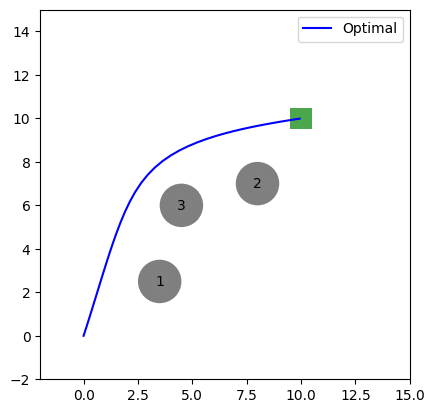

In [6]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [7]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [8]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor = False, Lambda = 0.001):
    opt_traj_feat = cost_set.cum_feat(xs_optimal, us_optimal, dt)
    bad_traj_feat = cost_set.cum_feat(np.zeros_like(xs_optimal), np.zeros_like(us_optimal), dt)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        if use_factor:
            non_opt_traj_feat = cost_set.cum_feat(Xs, Us, dt)
            alpha = np.exp((np.linalg.norm(opt_traj_feat - non_opt_traj_feat))/(np.linalg.norm(opt_traj_feat - bad_traj_feat))**2)
            den += np.max([np.nextafter(0,1),alpha*np.exp(-non_opt_traj_cost)])
        else:
            den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    # output += Lambda*np.linalg.norm(x - w_old)
    return output

def fcn_w_2(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor = False, Lambda = 0.001):
    
    nr = cost_set.nr
    opt_traj_feat = cost_set.cum_feat(xs_optimal, us_optimal, dt)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    
    num += np.exp(-opt_traj_cost)
    den += num
    feats = np.zeros(len(xs_non_optimal_set))
    if use_factor:
        for i, (Xs, Us) in enumerate(zip(xs_non_optimal_set, us_non_optimal_set)):
            feats[i] = np.linalg.norm(cost_set.cum_feat(Xs, Us, dt) - opt_traj_feat)
    worst = np.max(feats)
    for feat, Xs, Us in zip(feats, xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        if use_factor:
            alpha = np.exp((feat/worst)**2)
            den += np.max([np.nextafter(0,1),alpha*np.exp(-non_opt_traj_cost)])
        else:
            den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def get_optimality(cost_set,x_des,u_des,x_set,u_set,dt):
    opt_vals = np.zeros(len(x_set))
    opt_feat = cost_set.cum_feat(x_des, u_des, dt)
    for i, (Xs, Us) in enumerate(zip(x_set,u_set)):
        traj_feat = cost_set.cum_feat(Xs, Us, dt)
        opt_vals[i] = np.linalg.norm(opt_feat - traj_feat)
    return opt_vals

def pick_best(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[-num:][::-1]
    return inds

def pick_worst(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[:num][::-1]
    return inds

In [10]:
dt = timeStep
Lambda = 0.001
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 3, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
use_factor = True

w0 = w_bad
w_loop = w0
w_prev = w0
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 30
it_max_sqp = 3
fcn = fcn_w

xs = []
us = []
ws = []
Fcns= []
W_Diffs = []
Traj_Diffs = []
Opt_Vals = []

xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)
Opt_Vals.append(1.0)
Traj_Diffs.append(1.0)

xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.00001
opt_tol = 5e-4
optimality = 1
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt)
non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt)
stop = 1
# while optimality > opt_tol and it < it_max_IRL:
while stop > 1e-7 and it < it_max_IRL:
    sqp_non_opt = reset_weights(sqp_non_opt, w0[:nr], w0[nr:])
    
    # With simple regulation: ||w||
    res = minimize(fcn, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, use_factor, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    # # With simple new regulation: ||w - w_old||
    # res = minimize(fcn_w_new, 
    #                w0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_prev, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    
    w_loop = res.x.copy()
    if np.max(w_loop) != 0:
        w_loop /= np.max(w_loop)
    fcn_value = fcn(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)
    # fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(sqp_non_opt.xs.tolist().copy(), sqp_non_opt.us.tolist().copy(), dt)
    # traj_optimality = np.exp(-(np.linalg.norm(opt_feat-traj_feat)))
    # traj_nonoptimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat))
    optimality = ((np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)))**2
    Opt_Vals.append(optimality)
    
    if len(xs) < max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        inds = pick_best(Opt_Vals,max_set_size)
        # inds = pick_worst(Opt_Vals,max_set_size)
        xs_non_optimal_set = [xs[i] for i in inds]
        us_non_optimal_set = [us[i] for i in inds]
        # fcn = fcn_w_2
        
    
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)

    stop = traj_diff*optimality
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimality Divergence: {:.4f} || Stop {:.5f}'.format(
            fcn_value, w_diff, traj_diff, optimality, stop
        ))
    
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    
    w_prev = w0
    it += 1
    # if it == it_max_IRL-1:
    #     # options['maxiter'] = 200
    #     xs_non_optimal_set = xs
    #     us_non_optimal_set = us

print(res)
w_irl = res.x/np.max(res.x)
# w_irl = ws[ws.index(min(ws))+1]

Fcn Value: 0.0012 || Weight Diff: 0.0000 || Traj Diff: 445.6343, || Optimality Divergence: 24.2497 || Stop 10806.47917
Fcn Value: 0.0012 || Weight Diff: 0.2424 || Traj Diff: 8264.7214, || Optimality Divergence: 24.2497 || Stop 200416.65792
Fcn Value: 0.0012 || Weight Diff: 0.0000 || Traj Diff: 3631.4573, || Optimality Divergence: 0.5144 || Stop 1867.96334
Fcn Value: 0.1305 || Weight Diff: 0.5912 || Traj Diff: 6297.7581, || Optimality Divergence: 0.5144 || Stop 3239.46566
Fcn Value: 0.0054 || Weight Diff: 0.0593 || Traj Diff: 63.6990, || Optimality Divergence: 0.2216 || Stop 14.11846
Fcn Value: 1.1779 || Weight Diff: 0.0005 || Traj Diff: 1.0158, || Optimality Divergence: 0.1658 || Stop 0.16843
Fcn Value: 1.3961 || Weight Diff: 0.0243 || Traj Diff: 6.8306, || Optimality Divergence: 0.1735 || Stop 1.18491
Fcn Value: 1.8071 || Weight Diff: 0.0005 || Traj Diff: 0.5903, || Optimality Divergence: 0.2127 || Stop 0.12557
Fcn Value: 2.0655 || Weight Diff: 0.0062 || Traj Diff: 0.4076, || Optimali

KeyboardInterrupt: 

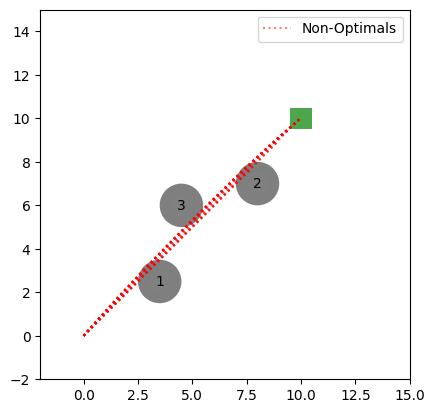

In [11]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [ ]:
n = Opt_Vals.index(min(Opt_Vals))
m = Traj_Diffs.index(min(Traj_Diffs))
A = np.stack(Opt_Vals)*np.stack(Traj_Diffs)
plt.plot(Opt_Vals); plt.show()
# plt.plot(Traj_Diffs); plt.show()
# plt.plot(A)
print(n, min(Opt_Vals))
print(m, min(Traj_Diffs))
print(np.min(A))

In [ ]:
# w_irl = ws[n]
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

In [ ]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

In [ ]:
HTML(animateTraj(xs_optimal, xs, obs_set, target_high, sleep=500, animType=2).to_jshtml())

In [ ]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

In [ ]:
print(plot_tested_model(XS_Set, obs_set, target_high))
# print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

In [ ]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

In [ ]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [ ]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [ ]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

In [ ]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [ ]:
# # Add a noisy trajectory to the set
# # scale = 1/traj_diff + 1.0
# scale = 5.0
# noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
# us.append(noisy_u)
# xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))